<a href="https://colab.research.google.com/github/Nobu90/scaling-broccoli/blob/main/sentence_piece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 루브릭 

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?

SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

# 환경 세팅

In [1]:
! pip install sentencepiece
! pip install matplotlib
!sudo apt-get install g++ openjdk-7-jdk python-dev python3-dev   
!pip3 install JPype1-py3
!pip3 install konlpy   
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp38-cp38-linux_x86_64.whl size=3484414 s

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

import konlpy
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.initializers import Constant

import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

from collections import Counter

import sentencepiece as spm
import time
import os

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)
!python --version

2.11.0
1.21.6
1.3.5
0.6.0
3.6.0
Python 3.8.10


# Mecab - Morphs

## 데이터 로드

In [148]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


## 결측치 제거

In [149]:
train_data = train_data.dropna()
test_data = test_data.dropna()

print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


## 문장 길이 분석

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


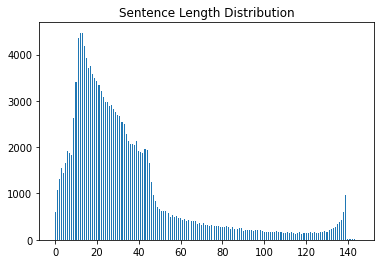

In [150]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=0.5)
plt.title("Sentence Length Distribution")
plt.show()

In [151]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in train_data['document']:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [152]:
check_sentence_with_length(train_data['document'], 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [154]:
max_len = 60
min_len = 5

train_data = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len)]
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len)]

test_data = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len)]
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len)]

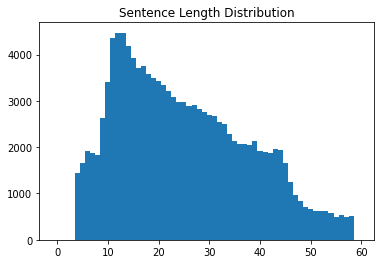

In [155]:
sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [141]:
print(train_data.shape)
print(test_data.shape)

(124408,)
(41409,)


## 불용어 제거 및 토큰화

In [143]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=50000):
    
    X_train = []
    for sentence in train_corpus:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_corpus:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(50000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_corpus)), X_test, np.array(list(test_corpus)), word_to_index

    X_train, y_train, X_test, y_test, word_to_index = load_data(train_corpus, test_corpus) 

In [147]:
print(len(X_train))
print(len(X_test))

99526
41409


In [133]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[4])
print(index_to_word[5])
print(word_to_index['영화'])

.
영화
5


In [134]:
print(len(index_to_word))

42713


In [135]:
word_to_index = {k:(v) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])    
print(word_to_index['the']) 
print(index_to_word[3]) 
print(index_to_word[4])    
print(index_to_word[5])
print(word_to_index['영화'])

<BOS>
1865
<UNUSED>
.
영화
5


In [136]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 패딩 추가

In [137]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre')
                                                        

test_data = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre')
                                                    

print(train_data.shape)
print(test_data.shape)

(99526, 94)
(41409, 48)


## 테스트 데이터 분리

In [138]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

ValueError: ignored

## 임베딩 사이즈 및 차원 설정

In [139]:
vocab_size = 50000
word_vector_dim = 100

## Mecab_morphs_lstm 모델

In [112]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(256))   
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         5000000   
                                                                 
 lstm_2 (LSTM)               (None, 256)               365568    
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 학습

In [113]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

lstm_history = lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
195/195 [==============================] - 30s 143ms/step - loss: 0.4742 - accuracy: 0.7798 - val_loss: 0.3696 - val_accuracy: 0.8410
Epoch 2/5
195/195 [==============================] - 16s 84ms/step - loss: 0.3108 - accuracy: 0.8705 - val_loss: 0.3572 - val_accuracy: 0.8474
Epoch 3/5
195/195 [==============================] - 15s 79ms/step - loss: 0.2616 - accuracy: 0.8965 - val_loss: 0.3610 - val_accuracy: 0.8453
Epoch 4/5
195/195 [==============================] - 12s 64ms/step - loss: 0.2268 - accuracy: 0.9130 - val_loss: 0.3793 - val_accuracy: 0.8411
Epoch 5/5
195/195 [==============================] - 14s 73ms/step - loss: 0.1991 - accuracy: 0.9249 - val_loss: 0.4127 - val_accuracy: 0.8417


## 결과 데이터

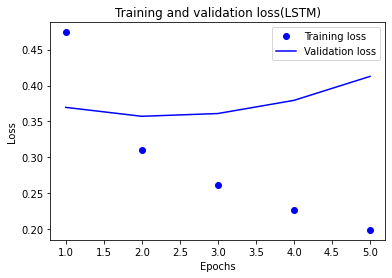

In [114]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

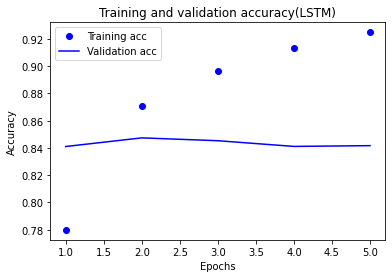

In [115]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
lstm_results = lstm_model.evaluate(test_data,  y_test, verbose=2)

print(lstm_results)

1295/1295 - 5s - loss: 0.4191 - accuracy: 0.8374 - 5s/epoch - 4ms/step
[0.4191026985645294, 0.8374025225639343]


# Sentencepiece - Unigram

## 데이터 초기화

In [117]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

In [120]:
start = time.time()

temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_uigram'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=unigram_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

end = time.time()
print(end - start)

19.76498246192932


In [121]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("/content/unigram_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [122]:
s = spm.SentencePieceProcessor()
s.Load('/content/unigram_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

print(train_data.shape)
print(test_data.shape)

(123040, 38)
(41198, 40)


## 데이터 분리

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## 유니그램 모델

In [ ]:
ugm_lstm_model = tf.keras.Sequential()
ugm_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
ugm_lstm_model.add(tf.keras.layers.LSTM(256))   
ugm_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
ugm_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

ugm_lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_11 (LSTM)              (None, 256)               365568    
                                                                 
 dense_22 (Dense)            (None, 8)                 2056      
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()

ugm_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

ugm_lstm_history = ugm_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()
print(end - start)

Epoch 1/5
385/385 [==============================] - 36s 88ms/step - loss: 0.4302 - accuracy: 0.7958 - val_loss: 0.3555 - val_accuracy: 0.8448
Epoch 2/5
385/385 [==============================] - 13s 34ms/step - loss: 0.2534 - accuracy: 0.8970 - val_loss: 0.3699 - val_accuracy: 0.8426
Epoch 3/5
385/385 [==============================] - 9s 23ms/step - loss: 0.1813 - accuracy: 0.9293 - val_loss: 0.4175 - val_accuracy: 0.8385
Epoch 4/5
385/385 [==============================] - 8s 22ms/step - loss: 0.1227 - accuracy: 0.9522 - val_loss: 0.5504 - val_accuracy: 0.8312
Epoch 5/5
385/385 [==============================] - 7s 18ms/step - loss: 0.0827 - accuracy: 0.9674 - val_loss: 0.6829 - val_accuracy: 0.8291


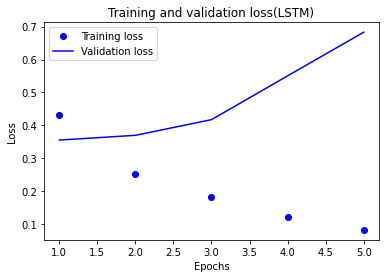

In [ ]:
ugm_lstm_history_dict = ugm_lstm_history.history

acc = ugm_lstm_history_dict['accuracy']
val_acc = ugm_lstm_history_dict['val_accuracy']
loss = ugm_lstm_history_dict['loss']
val_loss = ugm_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

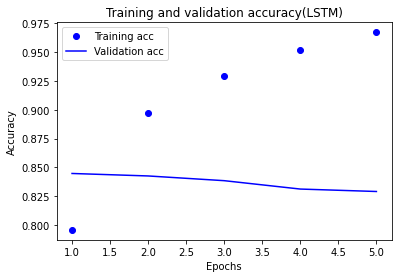

In [ ]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
ugm_lstm_results = ugm_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 5s - loss: 0.6868 - accuracy: 0.8267 - 5s/epoch - 4ms/step


# Sentencepiece - BPE

## 데이터 초기화

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

## BPE 옵션 학습

In [ ]:
temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_bpe'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=bpe_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)


ls: cannot access 'bpm_spm*': No such file or directory


In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./bpe_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('/content/bpe_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## BPE 모델

In [ ]:
bpm_lstm_model = tf.keras.Sequential()
bpm_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
bpm_lstm_model.add(tf.keras.layers.LSTM(256))   
bpm_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
bpm_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

bpm_lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_12 (LSTM)              (None, 256)               365568    
                                                                 
 dense_24 (Dense)            (None, 8)                 2056      
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
bpm_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

bpm_lstm_history = bpm_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()

print(end - start)

Epoch 1/5
385/385 [==============================] - 35s 84ms/step - loss: 0.4367 - accuracy: 0.7910 - val_loss: 0.3532 - val_accuracy: 0.8456
Epoch 2/5
385/385 [==============================] - 12s 31ms/step - loss: 0.2499 - accuracy: 0.8988 - val_loss: 0.3623 - val_accuracy: 0.8429
Epoch 3/5
385/385 [==============================] - 9s 22ms/step - loss: 0.1665 - accuracy: 0.9338 - val_loss: 0.4260 - val_accuracy: 0.8382
Epoch 4/5
385/385 [==============================] - 8s 22ms/step - loss: 0.1056 - accuracy: 0.9573 - val_loss: 0.6034 - val_accuracy: 0.8332
Epoch 5/5
385/385 [==============================] - 6s 16ms/step - loss: 0.0698 - accuracy: 0.9710 - val_loss: 0.7902 - val_accuracy: 0.8314
69.89597010612488


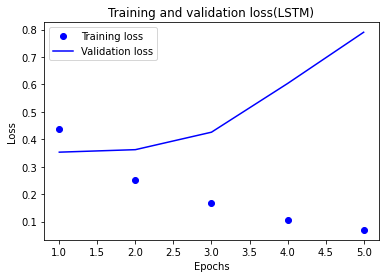

In [ ]:
bpm_lstm_history_dict = bpm_lstm_history.history

acc = bpm_lstm_history_dict['accuracy']
val_acc = bpm_lstm_history_dict['val_accuracy']
loss = bpm_lstm_history_dict['loss']
val_loss = bpm_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

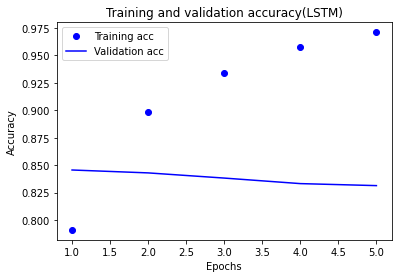

In [ ]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
bpm_lstm_results = bpm_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 5s - loss: 0.8222 - accuracy: 0.8282 - 5s/epoch - 4ms/step


# Sentencepiece - Char

## 데이터 초기화

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

## Char 옵션 학습

In [ ]:
temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_char'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=char_spm --vocab_size={} --model_type=char'.format(temp_file, vocab_size)    
)

-rw-r--r-- 1 root root 258478 Feb 22 08:58 char_spm.model
-rw-r--r-- 1 root root  22361 Feb 22 08:58 char_spm.vocab


In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./char_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('/content/char_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

## 데이터 분리

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## Char_lstm 모델

In [ ]:
char_lstm_model = tf.keras.Sequential()
char_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
char_lstm_model.add(tf.keras.layers.LSTM(256))   
char_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
char_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

char_lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_14 (LSTM)              (None, 256)               365568    
                                                                 
 dense_28 (Dense)            (None, 8)                 2056      
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## Char_lstm 학습

In [ ]:
start = time.time()
char_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

char_lstm_history = char_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()
print(end - start)

Epoch 1/10
385/385 [==============================] - 19s 43ms/step - loss: 0.4860 - accuracy: 0.7663 - val_loss: 0.4360 - val_accuracy: 0.7973
Epoch 2/10
385/385 [==============================] - 9s 23ms/step - loss: 0.4127 - accuracy: 0.8110 - val_loss: 0.4036 - val_accuracy: 0.8114
Epoch 3/10
385/385 [==============================] - 9s 23ms/step - loss: 0.3829 - accuracy: 0.8268 - val_loss: 0.3975 - val_accuracy: 0.8182
Epoch 4/10
385/385 [==============================] - 8s 21ms/step - loss: 0.3615 - accuracy: 0.8375 - val_loss: 0.3784 - val_accuracy: 0.8257
Epoch 5/10
385/385 [==============================] - 8s 22ms/step - loss: 0.3447 - accuracy: 0.8477 - val_loss: 0.3756 - val_accuracy: 0.8285
Epoch 6/10
385/385 [==============================] - 8s 20ms/step - loss: 0.3313 - accuracy: 0.8543 - val_loss: 0.3822 - val_accuracy: 0.8326
Epoch 7/10
385/385 [==============================] - 9s 22ms/step - loss: 0.3183 - accuracy: 0.8616 - val_loss: 0.3664 - val_accuracy: 0.832

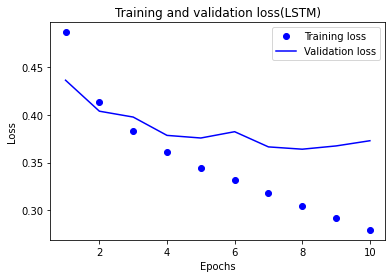

In [ ]:
char_lstm_history_dict = char_lstm_history.history

acc = char_lstm_history_dict['accuracy']
val_acc = char_lstm_history_dict['val_accuracy']
loss = char_lstm_history_dict['loss']
val_loss = char_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

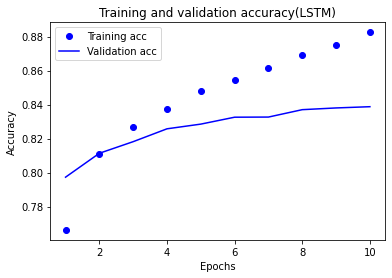

In [ ]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
char_lstm_results = char_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 4s - loss: 0.3699 - accuracy: 0.8387 - 4s/epoch - 3ms/step
